In [0]:
%tensorflow_version 2.x

In [0]:
import zipfile
zfile = zipfile.ZipFile("drive/My Drive/dog_cat.zip")
zfile.extractall("dataset")

In [3]:
import glob
import pandas as pd

catfn = glob.glob("dataset/train/cat.*")
catans = [0] * len(catfn)
dogfn = glob.glob("dataset/train/dog.*")
dogans = [1] * len(dogfn)
df = pd.DataFrame({
    "path":catfn + dogfn,
    "target":catans + dogans
})
df

,path,target
0,dataset/train/cat.6317.jpg,0
1,dataset/train/cat.1389.jpg,0
2,dataset/train/cat.9962.jpg,0
3,dataset/train/cat.7198.jpg,0
4,dataset/train/cat.3849.jpg,0
...,...,...
24995,dataset/train/dog.3332.jpg,1
24996,dataset/train/dog.11010.jpg,1
24997,dataset/train/dog.9438.jpg,1
24998,dataset/train/dog.7052.jpg,1


(482, 476)


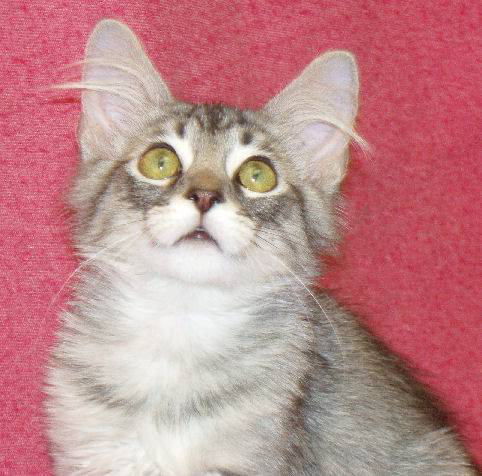

In [4]:
from tensorflow.keras.preprocessing.image import load_img
p = "dataset/train/cat.10544.jpg"
img = load_img(p)
print(img.size)
img


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
cnn.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
model = Sequential()

for l in cnn.layers:
  # trainable 一定要設, compile 前設定好
  l.trainable = False
  model.add(l)
# 自已的MLP
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [7]:
# 語法測試用
def test():
  return int
test()(3.14)

3

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization

for l in cnn.layers:
  l.trainable = False
x = BatchNormalization()(cnn.output)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
# 多輸入
from tensorflow.keras.layers import Input, Concatenate
img1 = Input(shape=(224, 224,3))
img1_cnn = cnn(img1)
img2 = Input(shape=(224, 224,3))
img2_cnn = cnn(img2)
combine = Concatenate()([img1_cnn, img2_cnn])
x = Flatten()(combine)
out = Dense(1, activation="sigmoid")(x)
# Model(inputs=[img1, img2], outputs=out).summary()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=["accuracy"])

In [0]:
# 好習慣: 全部轉成numpy array
import numpy as np
from sklearn.model_selection import train_test_split
x, y = np.array(df["path"]), np.array(df["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [12]:
from tensorflow.keras.applications.vgg16 import preprocess_input
# return value: (原圖, 預處理過圖, 答案)
def dataflow(paths, targets, BATCH=20):
  idx = np.random.randint(0, x.shape[0], size=BATCH)
  img_raw, img_process = [], []
  for p in x[idx]:
    img = load_img(p, target_size=(224, 224))
    img_np = np.array(img)
    img_raw.append(img_np)
    img_pre = preprocess_input(img_np)
    img_process.append(img_pre)
  return(np.array(img_raw),
         np.array(img_process),
         np.array(y[idx]))
data = dataflow(x_train, y_train)
print(data[0].shape, data[1].shape, data[2].shape)

(20, 224, 224, 3) (20, 224, 224, 3) (20,)


In [17]:
for i in range(30):
  print("-"*15,i,"-"*15)
  raw, img, ans = dataflow(x_train, y_train)
  train_result = model.train_on_batch(img, ans)
  print("Train:", train_result)
  raw, img, ans = dataflow(x_test, y_test)
  test_result = model.test_on_batch(img, ans)
  print("Validate:", test_result)

--------------- 0 ---------------
Train: [0.05917804315686226, 1.0]
Validate: [0.7062432765960693, 0.949999988079071]
--------------- 1 ---------------
Train: [0.050354551523923874, 0.949999988079071]
Validate: [0.43370428681373596, 0.949999988079071]
--------------- 2 ---------------
Train: [0.08360890299081802, 1.0]
Validate: [0.03782200068235397, 1.0]
--------------- 3 ---------------
Train: [0.03983408585190773, 1.0]
Validate: [0.6365805864334106, 0.949999988079071]
--------------- 4 ---------------
Train: [0.056793056428432465, 1.0]
Validate: [3.1041617393493652, 0.949999988079071]
--------------- 5 ---------------
Train: [0.13276028633117676, 0.949999988079071]
Validate: [0.8082438707351685, 0.8999999761581421]
--------------- 6 ---------------
Train: [0.0672357901930809, 0.949999988079071]
Validate: [1.4263274669647217, 0.8999999761581421]
--------------- 7 ---------------
Train: [0.08924464881420135, 0.949999988079071]
Validate: [0.32399851083755493, 0.949999988079071]
--------

In [18]:
model.predict(img)

array([[2.3462822e-24, 1.0000000e+00],
       [1.0000000e+00, 9.4824102e-24],
       [7.5125279e-13, 1.0000000e+00],
       [1.0000000e+00, 1.0149844e-23],
       [1.2377566e-34, 1.0000000e+00],
       [7.0437047e-09, 1.0000000e+00],
       [9.8135424e-01, 1.8645775e-02],
       [1.0000000e+00, 2.8485821e-23],
       [1.0000000e+00, 2.0823807e-32],
       [1.0000000e+00, 1.2052502e-23],
       [1.0000000e+00, 6.9442822e-32],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 2.1981990e-10],
       [1.0000000e+00, 1.6087921e-21],
       [3.2398276e-02, 9.6760178e-01],
       [0.0000000e+00, 1.0000000e+00],
       [9.9060470e-01, 9.3953237e-03],
       [1.0000000e+00, 1.9680083e-28]], dtype=float32)

In [22]:
raw, img, ans = dataflow(x_test, y_test, 1000)
model.evaluate(img,ans)

32/32 [==============================] - 2s 65ms/step - loss: 0.6417 - accuracy: 0.9540


[0.6417441964149475, 0.9539999961853027]

In [27]:
# Model(非Sequential): 沒有predict_classes
pre = model.predict(img).argmax(axis=1)
pre

array([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,

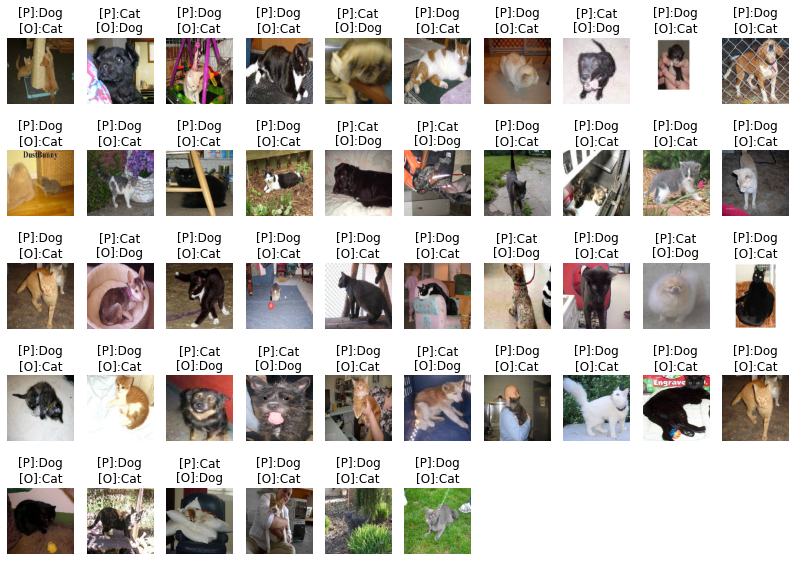

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
# [:200]: 太多錯, 我只取前兩百個
names = ["Cat", "Dog"]
idx = np.nonzero(pre != ans)[0]
false_pre_img = raw[idx]
false_pre_label = ans[idx]
false_pre_predict = pre[idx]

width = 10
height = len(idx) // width + 1
plt.figure(figsize=(14, 10))
for i, img in enumerate(false_pre_img):
    plt.subplot(height, width, i+1)
    t = "[P]:{}\n[O]:{}".format(names[false_pre_predict[i]],
                                names[false_pre_label[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)